In [15]:
from pathlib import Path
import warnings
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from mes_longslit import regrid_images

In [2]:
inpath = Path.cwd().parent / "data" / "wcs"
outpath = inpath.parent / "regrid"
outpath.mkdir(exist_ok=True)

These are the coordinates of `PN Ou 5` [according to SIMBAD](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PN+Ou+5)

In [3]:
c = SkyCoord("21 14 20.03 +43 41 36.0", unit=(u.hourangle, u.deg))
c

<SkyCoord (ICRS): (ra, dec) in deg
    (318.58345833, 43.69333333)>

In [34]:
results = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for infile in sorted(inpath.glob("*wcs.fits")):
        hdulist = fits.open(infile)
        results[infile.stem] = regrid_images(hdulist, center=c, shape=(256, 256))
    

In [35]:
results

{'crN10035_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7fb06b10a0>],
 'crN10042_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752a9ca0>],
 'crN20001_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752bf190>],
 'crN20008_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f74c854f0>],
 'crN20011_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752a6cd0>],
 'crspm0020o_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7fb06b6310>],
 'crspm0025o_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f30714e20>],
 'crspm0047o_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f74c866a0>],
 'crspm0052o_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752e60d0>],
 'crspm0053o_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f7530c310>],
 'crspm0058o_b-wcs': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752a9190>],
 'crspm0109o_b-wcs': [<astropy.io.fits.hdu

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

[None, None]

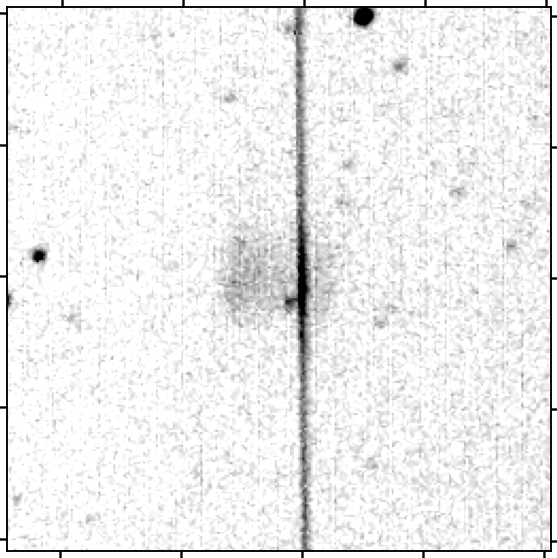

In [40]:
hdu = results["crN20011_b-wcs"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw=dict(projection=w)
)
ax.imshow(hdu.data, cmap="gray_r", vmin=-5, vmax=12)
ax.set(
    xlabel="RA",
    ylabel="DEC",
)

In [41]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 318.58345833333  43.693333333333  
CRPIX : 128.5  128.5  
CD1_1 CD1_2  : -4.05344062019e-07  -9.74613192003e-05  
CD2_1 CD2_2  : 9.74613192003e-05  -4.05344062019e-07  
NAXIS : 256  256

In [31]:
tform = ax.get_transform("icrs")

In [33]:
tform.get_matrix()

array([[ 1.06171875,  0.        , 97.73085938],
       [ 0.        ,  1.06171875, 90.53085938],
       [ 0.        ,  0.        ,  1.        ]])